In [1]:
import os
import cv2
import numpy as np

In [2]:
data_path="C:/hope/deep learning/face mask detection/dataset"

In [3]:
categories=["with_mask","without_mask"]

# now we r going to join the data path to the foler wher each category is present for os to easily access the folders

In [4]:
dataset=[]
for category in categories: 
    folder_path=os.path.join(data_path,category)
    label=categories.index(category)
    for file in os.listdir(folder_path):
        file_path=os.path.join(folder_path,file)
        img=cv2.imread(file_path)
        if img is not None:
            image=cv2.resize(img,(224,224))# detection models prefer this size
            dataset.append([image,label])
        
    # this whole function is for one image from for till dataset .append

In [5]:
img.shape

(194, 259, 3)

In [6]:
len(dataset)# so we hv in total 3823 images

3823

In [7]:
dataset[0][0].shape# shape of the first image in dataset



(224, 224, 3)

# 2. we r going to split the dataset to x and y

In [8]:
#x == numpy array of images with pixel values, y=labels
x=[]
y=[]
for image ,label in dataset:
    x.append(image)
    y.append(label)
    
    # once this is done we get x as an list of array of pixel values and y as a lisst both we need to convert before model creation
    #in to an array

In [9]:
x=np.array(x)
x.shape

(3823, 224, 224, 3)

In [10]:
y=np.array(y)
y.shape

(3823,)

# 3. now we r going to normalize x and y to standard values btw 0 and 1 before splitting

In [11]:
x=x/255 # where the 255 is the maximum pixel intensity value.
# for y we do one hot encoding after spliting y? to first clearly distinguish y_train,y_test then encode if required.

# 4. now we r going to split x and y

In [12]:
from sklearn.model_selection import train_test_split as tt
x_train,x_test,y_train,y_test=tt(x,y,test_size=0.3,random_state=0)

# now lets encode y

In [13]:
import tensorflow
from tensorflow.keras.utils import to_categorical # theres no np_utils in the new version of keras
y_train=to_categorical(y_train,num_classes=2)
y_test=to_categorical(y_test,num_classes=2)

In [14]:
y_train.shape

(2676, 2)

In [15]:
y_test.shape

(1147, 2)

In [16]:
# preprocessing check list 



# Loaded images
# Resized to same shape
# Converted to NumPy arrays
# Normalized X (0–1
# Split into train/test
# One-hot encoded y

# 5. model creation using transfer learning



In [17]:
# here i am using mobilenetv2 for faster tring,it hs already trained on multiple images so can easily recognise features on the face,
# its suitable for smaller input size.

# other pretrained models we can use r ResNet or VGG: but they r heavier and require lrger dataset

In [18]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D, Dropout, Flatten, Dense, Input
from tensorflow.keras.models import Model

In [19]:
base_model = MobileNetV2(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))


# pretrained weights of the Mobilenetv2 are beign loaded,y do we need pretrained weights?? because they r the stored features,
# spatial relationships,curves,edges, textures of 1.2 million images where face is also a part of.

# we r defining inputsize of each image as 224,224,3

# include_top=False means we r removing the ann base used to classify imageslike cat ,dog, etc but we r keeping the 

# cnn base where the features r stored. y is it cos ann is the part where its unique for evry model?
# its always better to create the ann part of every model to improve accuracy uncless our model also has 1000 classes like 
# mobilevnet.

9420800/9406464 [==============================] - 4s 0us/step


# 6. now we r going to create our own custom head or the ann part

In [20]:
# so now we r going to build our own custom ann head part:


head_model = base_model.output # this loads the cnn part 
head_model = AveragePooling2D(pool_size=(7, 7))(head_model)
head_model = Flatten(name="flatten")(head_model)
head_model = Dense(128, activation="relu")(head_model)
head_model = Dropout(0.5)(head_model)
head_model = Dense(2, activation="softmax")(head_model)

# here after each line of code we r writing (head_model) this is linking in keras where we link the output from the previeous
# layer to the output from the next layer
# head_model = base_model.output output from this is linked to AveragePooling2D(pool_size=(7, 7)) and saved in to head model
# and this then linked to Flatten(name="flatten"), till the final output layer and till we get the final head model.

In [21]:
head_model

<KerasTensor: shape=(None, 2) dtype=float32 (created by layer 'dense_1')>

# 7. now we r going to join the pretrained model and the head

In [22]:
from tensorflow.keras.models import Model

model = Model(inputs=base_model.input, outputs=head_model)

# here inputs=base_model.input here we passing the input layer of the base_model

In [23]:
for layer in base_model.layers:
    layer.trainable = False #  this will prevent the traing of the base layrs of MobileNetV2 during traing of the model and 
    # will train only the head part.

# 8. we r going to do model compiling

In [24]:
from tensorflow.keras.optimizers import Adam
INIT_LR = 1e-4       # Learning rate
         
opt = Adam(learning_rate=INIT_LR) # hyperparameters of adam y do u give? Smaller LR = slower learning (more stable)

model.compile(
    loss="binary_crossentropy",   # since 2 classes
    optimizer=opt,
    metrics=["accuracy"]
)

# 9. we rgoing to do model training

In [25]:
H = model.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    batch_size=32,
    epochs=20
)

Epoch 1/20
84/84 [==============================] - 269s 3s/step - loss: 0.4460 - accuracy: 0.8539 - val_loss: 0.1962 - val_accuracy: 0.9686
Epoch 2/20
84/84 [==============================] - 342s 4s/step - loss: 0.1945 - accuracy: 0.9496 - val_loss: 0.1092 - val_accuracy: 0.9704
Epoch 3/20
84/84 [==============================] - 230s 3s/step - loss: 0.1297 - accuracy: 0.9623 - val_loss: 0.0812 - val_accuracy: 0.9738
Epoch 4/20
84/84 [==============================] - 189s 2s/step - loss: 0.0952 - accuracy: 0.9757 - val_loss: 0.0674 - val_accuracy: 0.9765
Epoch 5/20
84/84 [==============================] - 230s 3s/step - loss: 0.0815 - accuracy: 0.9776 - val_loss: 0.0580 - val_accuracy: 0.9808
Epoch 6/20
84/84 [==============================] - 195s 2s/step - loss: 0.0660 - accuracy: 0.9862 - val_loss: 0.0507 - val_accuracy: 0.9817
Epoch 7/20
84/84 [==============================] - 221s 3s/step - loss: 0.0623 - accuracy: 0.9836 - val_loss: 0.0460 - val_accuracy: 0.9808
Epoch 8/20
84

# 10 now we predict y_test and convert them to readable form

In [27]:
y_pred = model.predict(x_test)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

# 11. Confusion Matrix

In [37]:
from sklearn.metrics import classification_report, confusion_matrix
cm = confusion_matrix(y_true_labels, y_pred_labels)

Text(0.5, 1, 'Confusion Matrix')

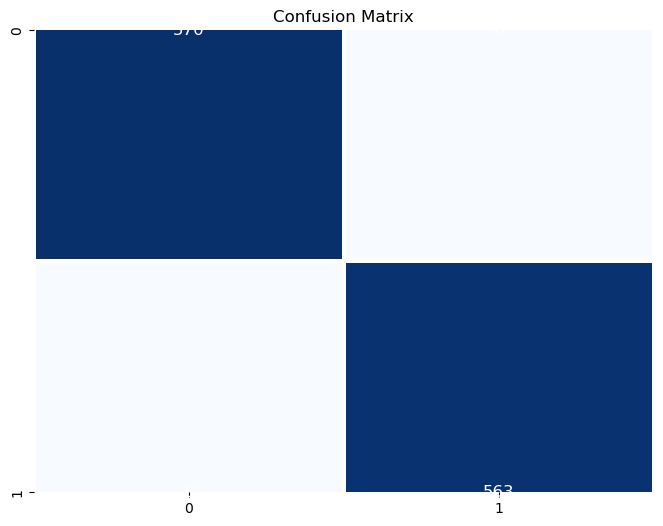

In [35]:

import seaborn as sns
import matplotlib.pyplot as plt


cm = confusion_matrix(y_true_labels, y_pred_labels)
plt.figure(figsize=(8, 6))

# 2) Plot the heatmap with center-aligned annotations and contrasting text color
sns.heatmap(cm, annot=True, fmt="d",cmap="Blues",annot_kws={ "ha": "center",  "va": "center",  "color": "white","fontsize": 12}
            ,linewidths=2, linecolor='white',cbar=False)
plt.title("Confusion Matrix")

# 12. classification report

In [32]:
print(classification_report(y_true_labels, y_pred_labels))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       576
           1       0.99      0.99      0.99       571

    accuracy                           0.99      1147
   macro avg       0.99      0.99      0.99      1147
weighted avg       0.99      0.99      0.99      1147



# 13. save the model

In [33]:
model.save("mask_detector_model.h5")

C:\Users\nimmy\anaconda3\envs\aiml\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
